In the following notebook, we'll speedrun an introduction to the Google Agent Development Kit.

From Google:

What is ADK again?

As a reminder, ADK is a Python framework designed to streamline the development of applications powered by Large Language Models (LLMs). It offers robust building blocks for creating agents that can reason, plan, utilize tools, interact dynamically with users, and collaborate effectively within a team.

While, like usual, this is "just another Agent framework" - the documentation for this framework is incredible. Massive shoutout to Google's docs team on this one!

We'll work through the following steps:

Step 1: Initial Setup and Configuration
Step 2: Building a Simple Dice Rolling Agent
Step 3: Building a Team of Agents
Step 4: Adding Session State
Let's get started!

NOTE: This tutorial is modified from the amazing tutorial found here.

## Step 1: Initial Setup and Configuration

In [1]:
import os
import random
from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm # For multi-model support
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types # For creating message Content/Parts
from getpass import getpass

from dotenv import load_dotenv
import os


import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

# Load environment variables from .env file
load_dotenv()

True

Let's additionally setup some API keys from all our favourite providers.

In [2]:
# (Optional) Validate required keys
required_keys = [
    "GOOGLE_API_KEY",
    "OPENAI_API_KEY",
    "ANTHROPIC_API_KEY",
    "GOOGLE_GENAI_USE_VERTEXAI",
]

for key in required_keys:
    if not os.getenv(key):
        raise EnvironmentError(f"Missing required env var: {key}")


## Step 2: Building A Dice Rolling Agent
For the first look at the system - we're going to start as most agent framework examples do - with a python function we're going to use as a tool.

The normal tool creation best-practices apply here, as per usual:

The docstring isn't just a docstring, it's a prompt to help the LLM/Agent understand when, how, and why to use a tool.
Typehints aren't just typehints thanks to Pydantic they help describe exactly the format our tool is expecting.
Crafting a good tool is an important part of building great agents, and it's no different in Google's ADK.


Our tool is fairly straightforward:
Given an attribute modifier, a proficiency score, and a difficulty class - does the roll succeed or fail.

In [5]:
def roll_to_hit(attribute_modifier: int, proficiency: int, difficulty_class: int) -> dict:
    """Rolls a check to hit a target number.

    Args:
        attribute_modifier (int): The attribute modifier to roll.
        proficiency (int): The proficiency bonus to the attribute modifier.
        difficulty_class (int): The difficulty class to hit.

    Returns:
        dict: Results of the roll, including whether it was a success or failure.
    """
    print(f"--- Tool: roll_to_hit called for attribute_modifier: {attribute_modifier}, proficiency: {proficiency}, and difficulty_class: {difficulty_class} ---") # Log tool execution
    
    # roll data
    roll = random.randint(1, 20)
    roll_result = roll + attribute_modifier + proficiency
    if roll_result >= difficulty_class:
        return {"status": "success", "information": f"You rolled a {roll_result} and hit the target number of {difficulty_class}."}
    else:
        return {"status": "error", "error_message": f"You rolled a {roll_result} and did not hit the target number of {difficulty_class}."}
    
# Example tool usage (optional test)
print(roll_to_hit(3, 2, 15))
print(roll_to_hit(-1, 2, 12))

--- Tool: roll_to_hit called for attribute_modifier: 3, proficiency: 2, and difficulty_class: 15 ---
{'status': 'success', 'information': 'You rolled a 16 and hit the target number of 15.'}
--- Tool: roll_to_hit called for attribute_modifier: -1, proficiency: 2, and difficulty_class: 12 ---
{'status': 'error', 'error_message': 'You rolled a 11 and did not hit the target number of 12.'}


In [7]:
MODEL_GEMINI_2_0_FLASH = "gemini-2.0-flash"
MODEL_GPT_41 = "openai/gpt-4.1"
MODEL_CLAUDE_SONNET = "claude-3-5-sonnet-20240620"

We can see that our tool does what we'd expect it to do - which is roll some dice and add some numbers!

Let's look at how we create Agents in Google's ADK next.

Once again, we see a common pattern in the ADK - clear, specific instructions for our Agent, as well as a clear description. We also see the equipping of our Agent with a tool in its toolbelt.

In [8]:
AGENT_MODEL = MODEL_GEMINI_2_0_FLASH 

dice_rolling_agent = Agent(
    name="dice_rolling_agent_v1",
    model=AGENT_MODEL, # Can be a string for Gemini or a LiteLlm object
    description="Provides results for a dice roll/check to hit a target number.",
    instruction="You are a helpful dice rolling assistant. "
                "When the user asks to make a check against a specific DC with a modifier and attribute score"
                "use the 'roll_to_hit' tool to find the result. "
                "If the tool returns an error, inform the user politely. "
                "If the tool is successful, present the result clearly.",
    tools=[roll_to_hit], # Pass the function directly
)

print(f"Agent '{dice_rolling_agent.name}' created using model '{AGENT_MODEL}'.")

Agent 'dice_rolling_agent_v1' created using model 'gemini-2.0-flash'.


Next up - we need to set our session, which is essentially analogous to State from frameworks like LangGraph.

We'll also set our Runner. When people say "Agents are just while loops", the Runner is the component they're referring to.

In [9]:
session_service = InMemorySessionService()

# Define constants for identifying the interaction context
APP_NAME = "dice_rolling_tutorial_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # Using a fixed ID for simplicity

# Create the specific session where the conversation will happen
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

# --- Runner ---
# Key Concept: Runner orchestrates the agent execution loop.
runner = Runner(
    agent=dice_rolling_agent, # The agent we want to run
    app_name=APP_NAME,   # Associates runs with our app
    session_service=session_service # Uses our session manager
)
print(f"Runner created for agent '{runner.agent.name}'.")

Session created: App='dice_rolling_tutorial_app', User='user_1', Session='session_001'
Runner created for agent 'dice_rolling_agent_v1'.


Finally, we need some kind of environment to run our Runner in!

We're going to create this for our notebook using this async helper function.

A few things to note:

We need to convert our query into the expected ADK Content object format.
We loop through our Runner's events until we reach the final response

In [10]:
async def call_agent_async(query: str, runner, user_id, session_id):
  """Sends a query to the agent and prints the final response."""
  print(f"\n>>> User Query: {query}")

  # Prepare the user's message in ADK format
  content = types.Content(role='user', parts=[types.Part(text=query)])

  final_response_text = "Agent did not produce a final response." # Default

  # Key Concept: run_async executes the agent logic and yields Events.
  # We iterate through events to find the final answer.
  async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
      # You can uncomment the line below to see *all* events during execution
      # print(f"  [Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

      # Key Concept: is_final_response() marks the concluding message for the turn.
      if event.is_final_response():
          if event.content and event.content.parts:
             # Assuming text response in the first part
             final_response_text = event.content.parts[0].text
          elif event.actions and event.actions.escalate: # Handle potential errors/escalations
             final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
          # Add more checks here if needed (e.g., specific error codes)
          break # Stop processing events once the final response is found

  print(f"<<< Agent Response: {final_response_text}")

Now we can run our Agent, and see how it does!

In [11]:
async def run_conversation():
    await call_agent_async("I want to make a DC 15 check with a modifier of 2 and an attribute score of 3",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID)

    await call_agent_async("I have to make a DC 12 Dexterity check. I have +4 in Dexterity, with proficiency, and we're just level 1.",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID) # Expecting the tool's error message

    await call_agent_async("I just got targeted by a DC 12 Constitution check. I have +1 in Constitution, with no proficiency.",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID)

# Execute the conversation using await in an async context (like Colab/Jupyter)
await run_conversation()


>>> User Query: I want to make a DC 15 check with a modifier of 2 and an attribute score of 3
--- Tool: roll_to_hit called for attribute_modifier: 3, proficiency: 2, and difficulty_class: 15 ---
<<< Agent Response: You rolled a 17 and hit the target number of 15.


>>> User Query: I have to make a DC 12 Dexterity check. I have +4 in Dexterity, with proficiency, and we're just level 1.
--- Tool: roll_to_hit called for attribute_modifier: 4, proficiency: 2, and difficulty_class: 12 ---
<<< Agent Response: You rolled a 10 and did not hit the target number of 12.


>>> User Query: I just got targeted by a DC 12 Constitution check. I have +1 in Constitution, with no proficiency.
--- Tool: roll_to_hit called for attribute_modifier: 1, proficiency: 0, and difficulty_class: 12 ---
<<< Agent Response: You rolled a 15 and hit the target number of 12.



Step 3: Building a Team of Agents
Beyond just running a single Agent, we can also run multiple agents, and build teams of agents we can delegate to based on the tasks at hand.

In Google's ADK the primary method of building these teams is the "hierarchical agent" structure:

We build specialized agents that excel at certain tasks
We build a router, manager, or orchestrator (Google calls this the "root agent")
We allow the router to determine which agent handles which task
Let's look at our final "graph" to see exactly how this will wind up looking:
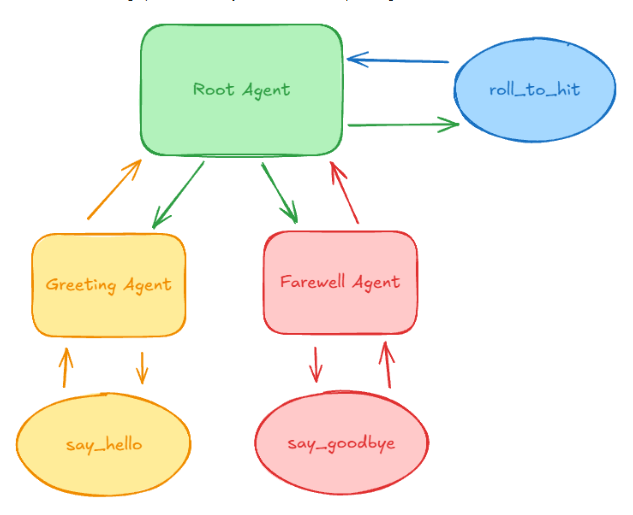
In order to get started with this, we'll need to do a couple important things:

Define the new tools we need for saying hello and goodbye
Building Agents that our root agent can delegate to
NOTE: It's important to notice that our root agent actually has access to a tool that it can call directly. It's not "just" a router, in this case, it's also a fully fledged Agent!

Our actual tools for saying hello and goodbye are extremely simple, as an example, but they can have arbitary complexity.

In [12]:
def say_hello(name: str = "there") -> str:
    """Provides a simple greeting, optionally addressing the user by name.

    Args:
        name (str, optional): The name of the person to greet. Defaults to "there".

    Returns:
        str: A friendly greeting message.
    """
    print(f"--- Tool: say_hello called with name: {name} ---")
    return f"Hello, {name}!"

def say_goodbye() -> str:
    """Provides a simple farewell message to conclude the conversation."""
    print(f"--- Tool: say_goodbye called ---")
    return "Goodbye! Have a great day."

print("Greeting and Farewell tools defined.")

# Optional self-test
print(say_hello("Alice"))
print(say_goodbye())

Greeting and Farewell tools defined.
--- Tool: say_hello called with name: Alice ---
Hello, Alice!
--- Tool: say_goodbye called ---
Goodbye! Have a great day.


We'll once again create our Agent, this time we'll create two - and we'll also spin them up with a suitable "power level" model, in gpt-4.1-nano.

In [13]:
greeting_agent = None
try:
    greeting_agent = Agent(
        # Using a potentially different/cheaper model for a simple task
        model=LiteLlm(model="openai/gpt-4.1-nano"),
        name="greeting_agent",
        instruction="You are the Greeting Agent. Your ONLY task is to provide a friendly greeting to the user. "
                    "Use the 'say_hello' tool to generate the greeting. "
                    "If the user provides their name, make sure to pass it to the tool. "
                    "Do not engage in any other conversation or tasks.",
        description="Handles simple greetings and hellos using the 'say_hello' tool.", # Crucial for delegation
        tools=[say_hello],
    )
    print(f"✅ Agent '{greeting_agent.name}' created using model '{greeting_agent.model}'.")
except Exception as e:
    print(f"❌ Could not create Greeting agent. Check API Key ({greeting_agent.model}). Error: {e}")

# --- Farewell Agent ---
farewell_agent = None
try:
    farewell_agent = Agent(
        # Can use the same or a different model
        model=LiteLlm(model="openai/gpt-4.1-nano"),
        name="farewell_agent",
        instruction="You are the Farewell Agent. Your ONLY task is to provide a polite goodbye message. "
                    "Use the 'say_goodbye' tool when the user indicates they are leaving or ending the conversation "
                    "(e.g., using words like 'bye', 'goodbye', 'thanks bye', 'see you'). "
                    "Do not perform any other actions.",
        description="Handles simple farewells and goodbyes using the 'say_goodbye' tool.", # Crucial for delegation
        tools=[say_goodbye],
    )
    print(f"✅ Agent '{farewell_agent.name}' created using model '{farewell_agent.model}'.")
except Exception as e:
    print(f"❌ Could not create Farewell agent. Check API Key ({farewell_agent.model}). Error: {e}")

✅ Agent 'greeting_agent' created using model 'model='openai/gpt-4.1-nano' llm_client=<google.adk.models.lite_llm.LiteLLMClient object at 0x7f62751ddfd0>'.
✅ Agent 'farewell_agent' created using model 'model='openai/gpt-4.1-nano' llm_client=<google.adk.models.lite_llm.LiteLLMClient object at 0x7f6274bde350>'.


Now we can create our "root agent".

Notice how we need to cover a few things:

The cases in which we should delegate to our sub_agents
The cases in which our root agent can perform the task directly.
Otherwise, this is the same process we used to set-up our original agent, with the inclusion of defining our sub_agents!

In [14]:
root_agent = None
runner_root = None # Initialize runner

if greeting_agent and farewell_agent and 'roll_to_hit' in globals():
    # Let's use a capable Gemini model for the root agent to handle orchestration
    root_agent_model = MODEL_GEMINI_2_0_FLASH

    dice_rolling_agent_team = Agent(
        name="dice_rolling_agent_v2", # Give it a new version name
        model=MODEL_GEMINI_2_0_FLASH,
        description="The main coordinator agent. Handles dice/check rolling requests and delegates greetings/farewells to specialists.",
        instruction="You are the main agent coordinating a team. Your primary responsibility is to provide dice/check rolling information. "
                    "Use the 'roll_to_hit' tool ONLY for specific dice/check rolling requests (e.g., 'I'm making a DC 15 check with a attribute modifier of 2 and a proficiency of 0'). "
                    "You have specialized sub-agents: "
                    "1. 'greeting_agent': Handles simple greetings like 'Hi', 'Hello'. Delegate to it for these. "
                    "2. 'farewell_agent': Handles simple farewells like 'Bye', 'See you'. Delegate to it for these. "
                    "Analyze the user's query. If it's a greeting, delegate to 'greeting_agent'. If it's a farewell, delegate to 'farewell_agent'. "
                    "If it's a dice/check rolling request, handle it yourself using 'roll_to_hit'. "
                    "For anything else, respond appropriately or state you cannot handle it.",
        tools=[roll_to_hit], # Root agent still needs the weather tool for its core task
        # Key change: Link the sub-agents here!
        sub_agents=[greeting_agent, farewell_agent]
    )
    print(f"✅ Root Agent '{dice_rolling_agent_team.name}' created using model '{root_agent_model}' with sub-agents: {[sa.name for sa in dice_rolling_agent_team.sub_agents]}")

else:
    print("❌ Cannot create root agent because one or more sub-agents failed to initialize or 'roll_to_hit' tool is missing.")
    if not greeting_agent: print(" - Greeting Agent is missing.")
    if not farewell_agent: print(" - Farewell Agent is missing.")
    if 'roll_to_hit' not in globals(): print(" - roll_to_hit function is missing.")

✅ Root Agent 'dice_rolling_agent_v2' created using model 'gemini-2.0-flash' with sub-agents: ['greeting_agent', 'farewell_agent']


Now we can test this out by calling our agents with various requests!

In [15]:
# Check if the root agent variable exists before defining the conversation function
root_agent_var_name = 'root_agent'
if 'dice_rolling_agent_team' in globals(): # Check if user used this name instead
    root_agent_var_name = 'dice_rolling_agent_team'
elif 'root_agent' not in globals():
    print("⚠️ Root agent ('root_agent' or 'dice_rolling_agent_team') not found. Cannot define run_team_conversation.")
    # Assign a dummy value to prevent NameError later if the code block runs anyway
    root_agent = None # Or set a flag to prevent execution

# Only define and run if the root agent exists
if root_agent_var_name in globals() and globals()[root_agent_var_name]:
    # Define the main async function for the conversation logic.
    # The 'await' keywords INSIDE this function are necessary for async operations.
    async def run_team_conversation():
        print("\n--- Testing Agent Team Delegation ---")
        session_service = InMemorySessionService()
        APP_NAME = "dice_rolling_tutorial_agent_team"
        USER_ID = "user_1_agent_team"
        SESSION_ID = "session_001_agent_team"
        session = await session_service.create_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
        )
        print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

        actual_root_agent = globals()[root_agent_var_name]
        runner_agent_team = Runner( # Or use InMemoryRunner
            agent=actual_root_agent,
            app_name=APP_NAME,
            session_service=session_service
        )
        print(f"Runner created for agent '{actual_root_agent.name}'.")

        # --- Interactions using await (correct within async def) ---
        await call_agent_async(query = "Hello there!",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)
        await call_agent_async(query = "I'm making a DC 15 check with a attribute modifier of 2 and a proficiency of 0",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)
        await call_agent_async(query = "Thanks, bye!",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)

    # --- Execute the `run_team_conversation` async function ---

    print("Attempting execution using 'await' (default for notebooks)...")
    await run_team_conversation()

else:
    # This message prints if the root agent variable wasn't found earlier
    print("\n⚠️ Skipping agent team conversation execution as the root agent was not successfully defined in a previous step.")

Attempting execution using 'await' (default for notebooks)...

--- Testing Agent Team Delegation ---
Session created: App='dice_rolling_tutorial_agent_team', User='user_1_agent_team', Session='session_001_agent_team'
Runner created for agent 'dice_rolling_agent_v2'.

>>> User Query: Hello there!
--- Tool: say_hello called with name: there ---
<<< Agent Response: Hello!

>>> User Query: I'm making a DC 15 check with a attribute modifier of 2 and a proficiency of 0
<<< Agent Response: It looks like you're working on a game-related task. I specialize in greetings and hellos. Would you like me to assist with anything else?

>>> User Query: Thanks, bye!
--- Tool: say_goodbye called ---
<<< Agent Response: Goodbye! Have a great day.


## Step 4: Adding Session State
Finally, we can talk about adding useful state to our Agent application!

Session state, like in other frameworks, can be used as a kind of memory as well as additional (and, obviously, stateful context) for tools and agents alike!

Let's look at how to use state to capture simple user preference.


In this example, we'll be using "Advantage" as a proxy for state. Advantage means when we roll our d20, we'll roll twice and keep the highest of the two rolls.

In [16]:
# Create a NEW session service instance for this state demonstration
session_service_stateful = InMemorySessionService()
print("✅ New InMemorySessionService created for state demonstration.")

# Define a NEW session ID for this part of the tutorial
SESSION_ID_STATEFUL = "session_state_demo_001"
USER_ID_STATEFUL = "user_state_demo"

# Define initial state data - user prefers Celsius initially
initial_state = {
    "user_advantage": "true",
}

# Create the session, providing the initial state
session_stateful = await session_service_stateful.create_session(
    app_name=APP_NAME, # Use the consistent app name
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
    state=initial_state # <<< Initialize state during creation
)
print(f"✅ Session '{SESSION_ID_STATEFUL}' created for user '{USER_ID_STATEFUL}'.")

# Verify the initial state was set correctly
retrieved_session = await session_service_stateful.get_session(app_name=APP_NAME,
                                                         user_id=USER_ID_STATEFUL,
                                                         session_id = SESSION_ID_STATEFUL)
print("\n--- Initial Session State ---")
if retrieved_session:
    print(retrieved_session.state)
else:
    print("Error: Could not retrieve session.")

✅ New InMemorySessionService created for state demonstration.
✅ Session 'session_state_demo_001' created for user 'user_state_demo'.

--- Initial Session State ---
{'user_advantage': 'true'}


Now we can modify our roll_to_hit tool to be state aware. We need to be able to:

Key into our state
Leverage the state to have some kind of impact on our tool call
Let's do exactly that below!

In [17]:
def roll_to_hit_stateful(attribute_modifier: int, proficiency: int, difficulty_class: int, tool_context: ToolContext) -> dict:
    """Used to roll a check to hit a target number.

    Args:
        attribute_modifier (int): The attribute modifier to roll.
        proficiency (int): The proficiency bonus to the attribute modifier.
        difficulty_class (int): The difficulty class to hit.

    Returns:
        dict: Results of the roll, including whether it was a success or failure.
    """
    print(f"--- Tool: roll_to_hit called for attribute_modifier: {attribute_modifier}, proficiency: {proficiency}, and difficulty_class: {difficulty_class} ---") # Log tool execution
    advantage = tool_context.state.get("user_advantage", "false")
    print(f"--- Tool: Reading state 'user_advantage': {advantage} ---")
    
    # roll data
    roll = random.randint(1, 20)
    if advantage == "true":
        second_roll = random.randint(1, 20)
        roll = max(roll, second_roll)

    roll_result = roll + attribute_modifier + proficiency
    if roll_result >= difficulty_class:
        return {"status": "success", "information": f"You rolled a {roll_result} and hit the target number of {difficulty_class}."}
    else:
        return {"status": "error", "error_message": f"You rolled a {roll_result} and did not hit the target number of {difficulty_class}."}

print("✅ State-aware 'roll_to_hit_stateful' tool defined.")

✅ State-aware 'roll_to_hit_stateful' tool defined.


In [18]:
greeting_agent = None
try:
    greeting_agent = Agent(
        model=LiteLlm(model="openai/gpt-4.1-nano"),
        name="greeting_agent",
        instruction="You are the Greeting Agent. Your ONLY task is to provide a friendly greeting using the 'say_hello' tool. Do nothing else.",
        description="Handles simple greetings and hellos using the 'say_hello' tool.",
        tools=[say_hello],
    )
    print(f"✅ Agent '{greeting_agent.name}' redefined.")
except Exception as e:
    print(f"❌ Could not redefine Greeting agent. Error: {e}")

# --- Redefine Farewell Agent (from Step 3) ---
farewell_agent = None
try:
    farewell_agent = Agent(
        model=LiteLlm(model="openai/gpt-4.1-nano"),
        name="farewell_agent",
        instruction="You are the Farewell Agent. Your ONLY task is to provide a polite goodbye message using the 'say_goodbye' tool. Do not perform any other actions.",
        description="Handles simple farewells and goodbyes using the 'say_goodbye' tool.",
        tools=[say_goodbye],
    )
    print(f"✅ Agent '{farewell_agent.name}' redefined.")
except Exception as e:
    print(f"❌ Could not redefine Farewell agent. Error: {e}")

# --- Define the Updated Root Agent ---
root_agent_stateful = None
runner_root_stateful = None # Initialize runner

# Check prerequisites before creating the root agent
if greeting_agent and farewell_agent and 'roll_to_hit_stateful' in globals():

    root_agent_model = MODEL_GEMINI_2_0_FLASH # Choose orchestration model

    root_agent_stateful = Agent(
        name="dice_rolling_agent_v4_stateful", # New version name
        model=MODEL_GEMINI_2_0_FLASH,
        description="Main agent: Provides dice/check rolling, delegates greetings/farewells, saves report to state.",
        instruction="You are the main Dice/Check Rolling Agent. Your job is to provide dice/check rolling using 'roll_to_hit_stateful'. "
                    "The tool will format the result based on user preference stored in state. "
                    "Delegate simple greetings to 'greeting_agent' and farewells to 'farewell_agent'. "
                    "Handle only dice/check rolling requests, greetings, and farewells.",
        tools=[roll_to_hit_stateful], # Use the state-aware tool
        sub_agents=[greeting_agent, farewell_agent], # Include sub-agents
        output_key="last_roll_result" # <<< Auto-save agent's final roll result
    )
    print(f"✅ Root Agent '{root_agent_stateful.name}' created using stateful tool and output_key.")

    # --- Create Runner for this Root Agent & NEW Session Service ---
    runner_root_stateful = Runner(
        agent=root_agent_stateful,
        app_name=APP_NAME,
        session_service=session_service_stateful # Use the NEW stateful session service
    )
    print(f"✅ Runner created for stateful root agent '{runner_root_stateful.agent.name}' using stateful session service.")

else:
    print("❌ Cannot create stateful root agent. Prerequisites missing.")
    if not greeting_agent: print(" - greeting_agent definition missing.")
    if not farewell_agent: print(" - farewell_agent definition missing.")
    if 'roll_to_hit_stateful' not in globals(): print(" - roll_to_hit_stateful tool missing.")

✅ Agent 'greeting_agent' redefined.
✅ Agent 'farewell_agent' redefined.
✅ Root Agent 'dice_rolling_agent_v4_stateful' created using stateful tool and output_key.
✅ Runner created for stateful root agent 'dice_rolling_agent_v4_stateful' using stateful session service.


In [19]:
if 'runner_root_stateful' in globals() and runner_root_stateful:
    # Define the main async function for the stateful conversation logic.
    # The 'await' keywords INSIDE this function are necessary for async operations.
    async def run_stateful_conversation():
        print("\n--- Testing State: Dice/Check Rolling & output_key ---")

        # 1. Check roll with advantage (Uses initial state: advantage = true)
        print("--- Turn 1: Requesting roll with advantage---")
        await call_agent_async(query= "I have a proficiency of +2, a Dexterity of 17, and the target DC is 15.",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )

        # 2. Manually update state preference to not have advantage - DIRECTLY MODIFY STORAGE
        print("\n--- Manually Updating State: Turning off advantage ---")
        try:
            # Access the internal storage directly - THIS IS SPECIFIC TO InMemorySessionService for testing
            # NOTE: In production with persistent services (Database), you would
            # typically update state via agent actions or specific service APIs if available,
            # not by direct manipulation of internal storage.
            stored_session = session_service_stateful.sessions[APP_NAME][USER_ID_STATEFUL][SESSION_ID_STATEFUL]
            stored_session.state["user_advantage"] = "false"
            # Optional: You might want to update the timestamp as well if any logic depends on it
            # import time
            # stored_session.last_update_time = time.time()
            print(f"--- Stored session state updated. Current 'user_advantage': {stored_session.state.get('user_advantage', 'Not Set')} ---") # Added .get for safety
        except KeyError:
            print(f"--- Error: Could not retrieve session '{SESSION_ID_STATEFUL}' from internal storage for user '{USER_ID_STATEFUL}' in app '{APP_NAME}' to update state. Check IDs and if session was created. ---")
        except Exception as e:
             print(f"--- Error updating internal session state: {e} ---")

        # 3. Check roll again (Tool should now use no advantage)
        # This will also update 'last_roll_result' via output_key
        print("\n--- Turn 2: Requesting roll without advantage ---")
        await call_agent_async(query= "I have a proficiency of +2, a Dexterity of 17, and the target DC is 15.",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )

        # 4. Test basic delegation (should still work)
        # This will update 'last_roll_result' again, overwriting the previous roll result
        print("\n--- Turn 3: Sending a greeting ---")
        await call_agent_async(query= "Hi!",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )

    # --- Execute the `run_stateful_conversation` async function ---

    # Direct await (Default for Notebooks/Async REPLs)
    # If your environment supports top-level await (like Colab/Jupyter notebooks),
    # it means an event loop is already running, so you can directly await the function.
    print("Attempting execution using 'await' (default for notebooks)...")
    await run_stateful_conversation()

    # --- Inspect final session state after the conversation ---
    # This block runs after either execution method completes.
    print("\n--- Inspecting Final Session State ---")
    final_session = await session_service_stateful.get_session(app_name=APP_NAME,
                                                         user_id= USER_ID_STATEFUL,
                                                         session_id=SESSION_ID_STATEFUL)
    if final_session:
        # Use .get() for safer access to potentially missing keys
        print(f"Final Advantage: {final_session.state.get('user_advantage', 'Not Set')}")
        print(f"Final Last Roll Result (from output_key): {final_session.state.get('last_roll_result', 'Not Set')}")
        # Print full state for detailed view
        # print(f"Full State Dict: {final_session.state.as_dict()}") # Use as_dict() for clarity
    else:
        print("\n❌ Error: Could not retrieve final session state.")

else:
    print("\n⚠️ Skipping state test conversation. Stateful root agent runner ('runner_root_stateful') is not available.")

Attempting execution using 'await' (default for notebooks)...

--- Testing State: Dice/Check Rolling & output_key ---
--- Turn 1: Requesting roll with advantage---

>>> User Query: I have a proficiency of +2, a Dexterity of 17, and the target DC is 15.
--- Tool: roll_to_hit called for attribute_modifier: 3, proficiency: 2, and difficulty_class: 15 ---
--- Tool: Reading state 'user_advantage': true ---
<<< Agent Response: You rolled a 12 and did not hit the target number of 15.


--- Manually Updating State: Turning off advantage ---
--- Stored session state updated. Current 'user_advantage': false ---

--- Turn 2: Requesting roll without advantage ---

>>> User Query: I have a proficiency of +2, a Dexterity of 17, and the target DC is 15.
--- Tool: roll_to_hit called for attribute_modifier: 3, proficiency: 2, and difficulty_class: 15 ---
--- Tool: Reading state 'user_advantage': false ---
<<< Agent Response: You rolled a 11 and did not hit the target number of 15.


--- Turn 3: Sending